In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from torchvision.utils import save_image, make_grid
from torchvision import transforms
from torchvision.datasets import MNIST

from ddpm import *
from conv_gnn import *

In [18]:
# Load the trained models
def load_trained_models(model_path, ep, device='mps'):
    # Define hyperparameters
    n_T = 400
    n_classes = 10
    n_feat = 128
    
    # Initialize the models
    # Context UNet for the DDPM model
    context_unet = ContextUnet(in_channels=1, n_feat=n_feat, n_classes=n_classes)
    
    # ImageSetGNN model
    distn_ae = ImageSetGNN(
        in_channels=1, hidden_channels=32, out_channels=32, hidden_dim=64, latent_dim=10,
        num_layers=2, kernel_size=3, pool_type='mean', agg_type='mean'
    )
    
    # DDPM model that uses the context UNet
    ddpm = DDPM(nn_model=context_unet, betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)
    
    # Load the saved model weights
    ddpm.load_state_dict(torch.load(model_path + f"model_{ep}.pth"))
    distn_ae.load_state_dict(torch.load(model_path + f"distn_ae_{ep}.pth"))
    
    return ddpm, distn_ae

ddpm, distn_ae = load_trained_models('../data/diffusion_outputs10/', 2)

/var/folders/6y/y7jr3zbd39b6fvmxt9lwswl00000gn/T/ipykernel_26445/2502844498.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ddpm.load_state_dict(torch.load(model_path +

In [19]:
# Function to sample MNIST sets for inference
def sample_mnist_sets(n_sets, set_size):
    transform = transforms.Compose([transforms.ToTensor()])
    dataset = MNIST(root="./data", train=True, download=True, transform=transform)
    
    label_to_indices = {i: torch.where(torch.tensor(dataset.targets) == i)[0] for i in range(10)}
    
    sets = []
    metadata = []
    for _ in range(n_sets):
        label = torch.randint(0, 10, (1,)).item()
        indices = torch.randperm(len(label_to_indices[label]))[:set_size]
        sets.append(dataset.data[label_to_indices[label][indices]].float().unsqueeze(1) / 255.0)
        metadata.append(label)
    
    return torch.stack(sets).float(), metadata

In [20]:
def generate_samples(ddpm, distn_ae, n_sample=40, guide_w=2.0, device="cuda" if torch.cuda.is_available() else "cpu"):
    ddpm = ddpm.to(device)
    distn_ae = distn_ae.to(device)

    # Sample some sets to get embeddings
    sample_sets, labels = sample_mnist_sets(1, 1000)
    sample_sets = sample_sets.to(device)
    
    # Get the distribution embedding using the GNN
    with torch.no_grad():
        c = distn_ae(sample_sets)

        c = c.repeat(n_sample, 1)
        # Generate samples using the diffusion model
        x_gen, x_gen_store = ddpm.sample(c, (1, 28, 28), device)
        #print(c)
    
    return x_gen, x_gen_store, c, labels

# Function to visualize the generated samples
def visualize_samples(x_gen, n_sample=40, n_classes=10):
    # Create a grid of images
    grid = make_grid(x_gen*-1 + 1, nrow=n_classes)
    
    # Plot the grid
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.title("Generated MNIST Samples")
    plt.show()

# Function to create a GIF of the generation process
def create_generation_gif(x_gen_store, filename="generation_process.gif", n_sample=40, n_classes=10):
    fig, axs = plt.subplots(nrows=int(n_sample/n_classes), ncols=n_classes, sharex=True, sharey=True, figsize=(10, 5))
    
    def animate_diff(i, x_gen_store):
        print(f'gif animating frame {i} of {x_gen_store.shape[0]}', end='\r')
        plots = []
        for row in range(int(n_sample/n_classes)):
            for col in range(n_classes):
                axs[row, col].clear()
                axs[row, col].set_xticks([])
                axs[row, col].set_yticks([])
                plots.append(axs[row, col].imshow(-x_gen_store[i, (row*n_classes)+col, 0], 
                                                cmap='gray', 
                                                vmin=(-x_gen_store[i]).min(), 
                                                vmax=(-x_gen_store[i]).max()))
        return plots
    
    ani = FuncAnimation(fig, animate_diff, fargs=[x_gen_store], interval=200, 
                       blit=False, repeat=True, frames=x_gen_store.shape[0])
    ani.save(filename, dpi=100, writer=PillowWriter(fps=5))
    print(f'Saved generation process animation to {filename}')

In [21]:
x_gen, x_gen_store, c, labels = generate_samples(ddpm, distn_ae, device='mps')

/var/folders/6y/y7jr3zbd39b6fvmxt9lwswl00000gn/T/ipykernel_26445/2652545778.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_to_indices = {i: torch.where(torch.tensor(dataset.targets) == i)[0] for i in range(10)}


In [22]:
c

tensor([[ 1.5661,  1.7812,  1.1136,  2.2967,  2.2648, -0.4775, -2.7998, -3.2888,
          1.4178,  1.6982],
        [ 1.5661,  1.7812,  1.1136,  2.2967,  2.2648, -0.4775, -2.7998, -3.2888,
          1.4178,  1.6982],
        [ 1.5661,  1.7812,  1.1136,  2.2967,  2.2648, -0.4775, -2.7998, -3.2888,
          1.4178,  1.6982],
        [ 1.5661,  1.7812,  1.1136,  2.2967,  2.2648, -0.4775, -2.7998, -3.2888,
          1.4178,  1.6982],
        [ 1.5661,  1.7812,  1.1136,  2.2967,  2.2648, -0.4775, -2.7998, -3.2888,
          1.4178,  1.6982],
        [ 1.5661,  1.7812,  1.1136,  2.2967,  2.2648, -0.4775, -2.7998, -3.2888,
          1.4178,  1.6982],
        [ 1.5661,  1.7812,  1.1136,  2.2967,  2.2648, -0.4775, -2.7998, -3.2888,
          1.4178,  1.6982],
        [ 1.5661,  1.7812,  1.1136,  2.2967,  2.2648, -0.4775, -2.7998, -3.2888,
          1.4178,  1.6982],
        [ 1.5661,  1.7812,  1.1136,  2.2967,  2.2648, -0.4775, -2.7998, -3.2888,
          1.4178,  1.6982],
        [ 1.5661,  

In [23]:
labels

[5]

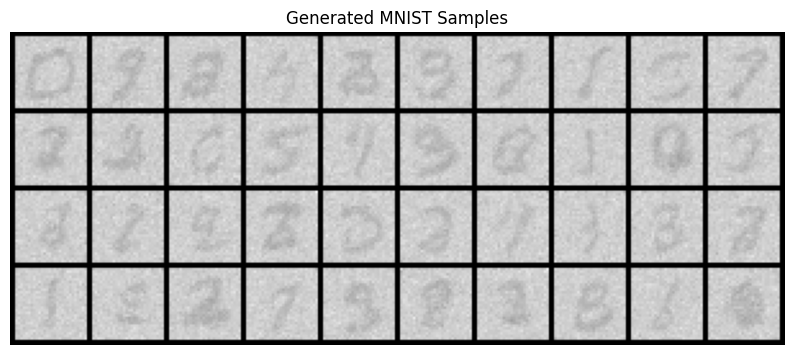

[5]

In [24]:
visualize_samples(x_gen - x_gen.min(), 40)
labels